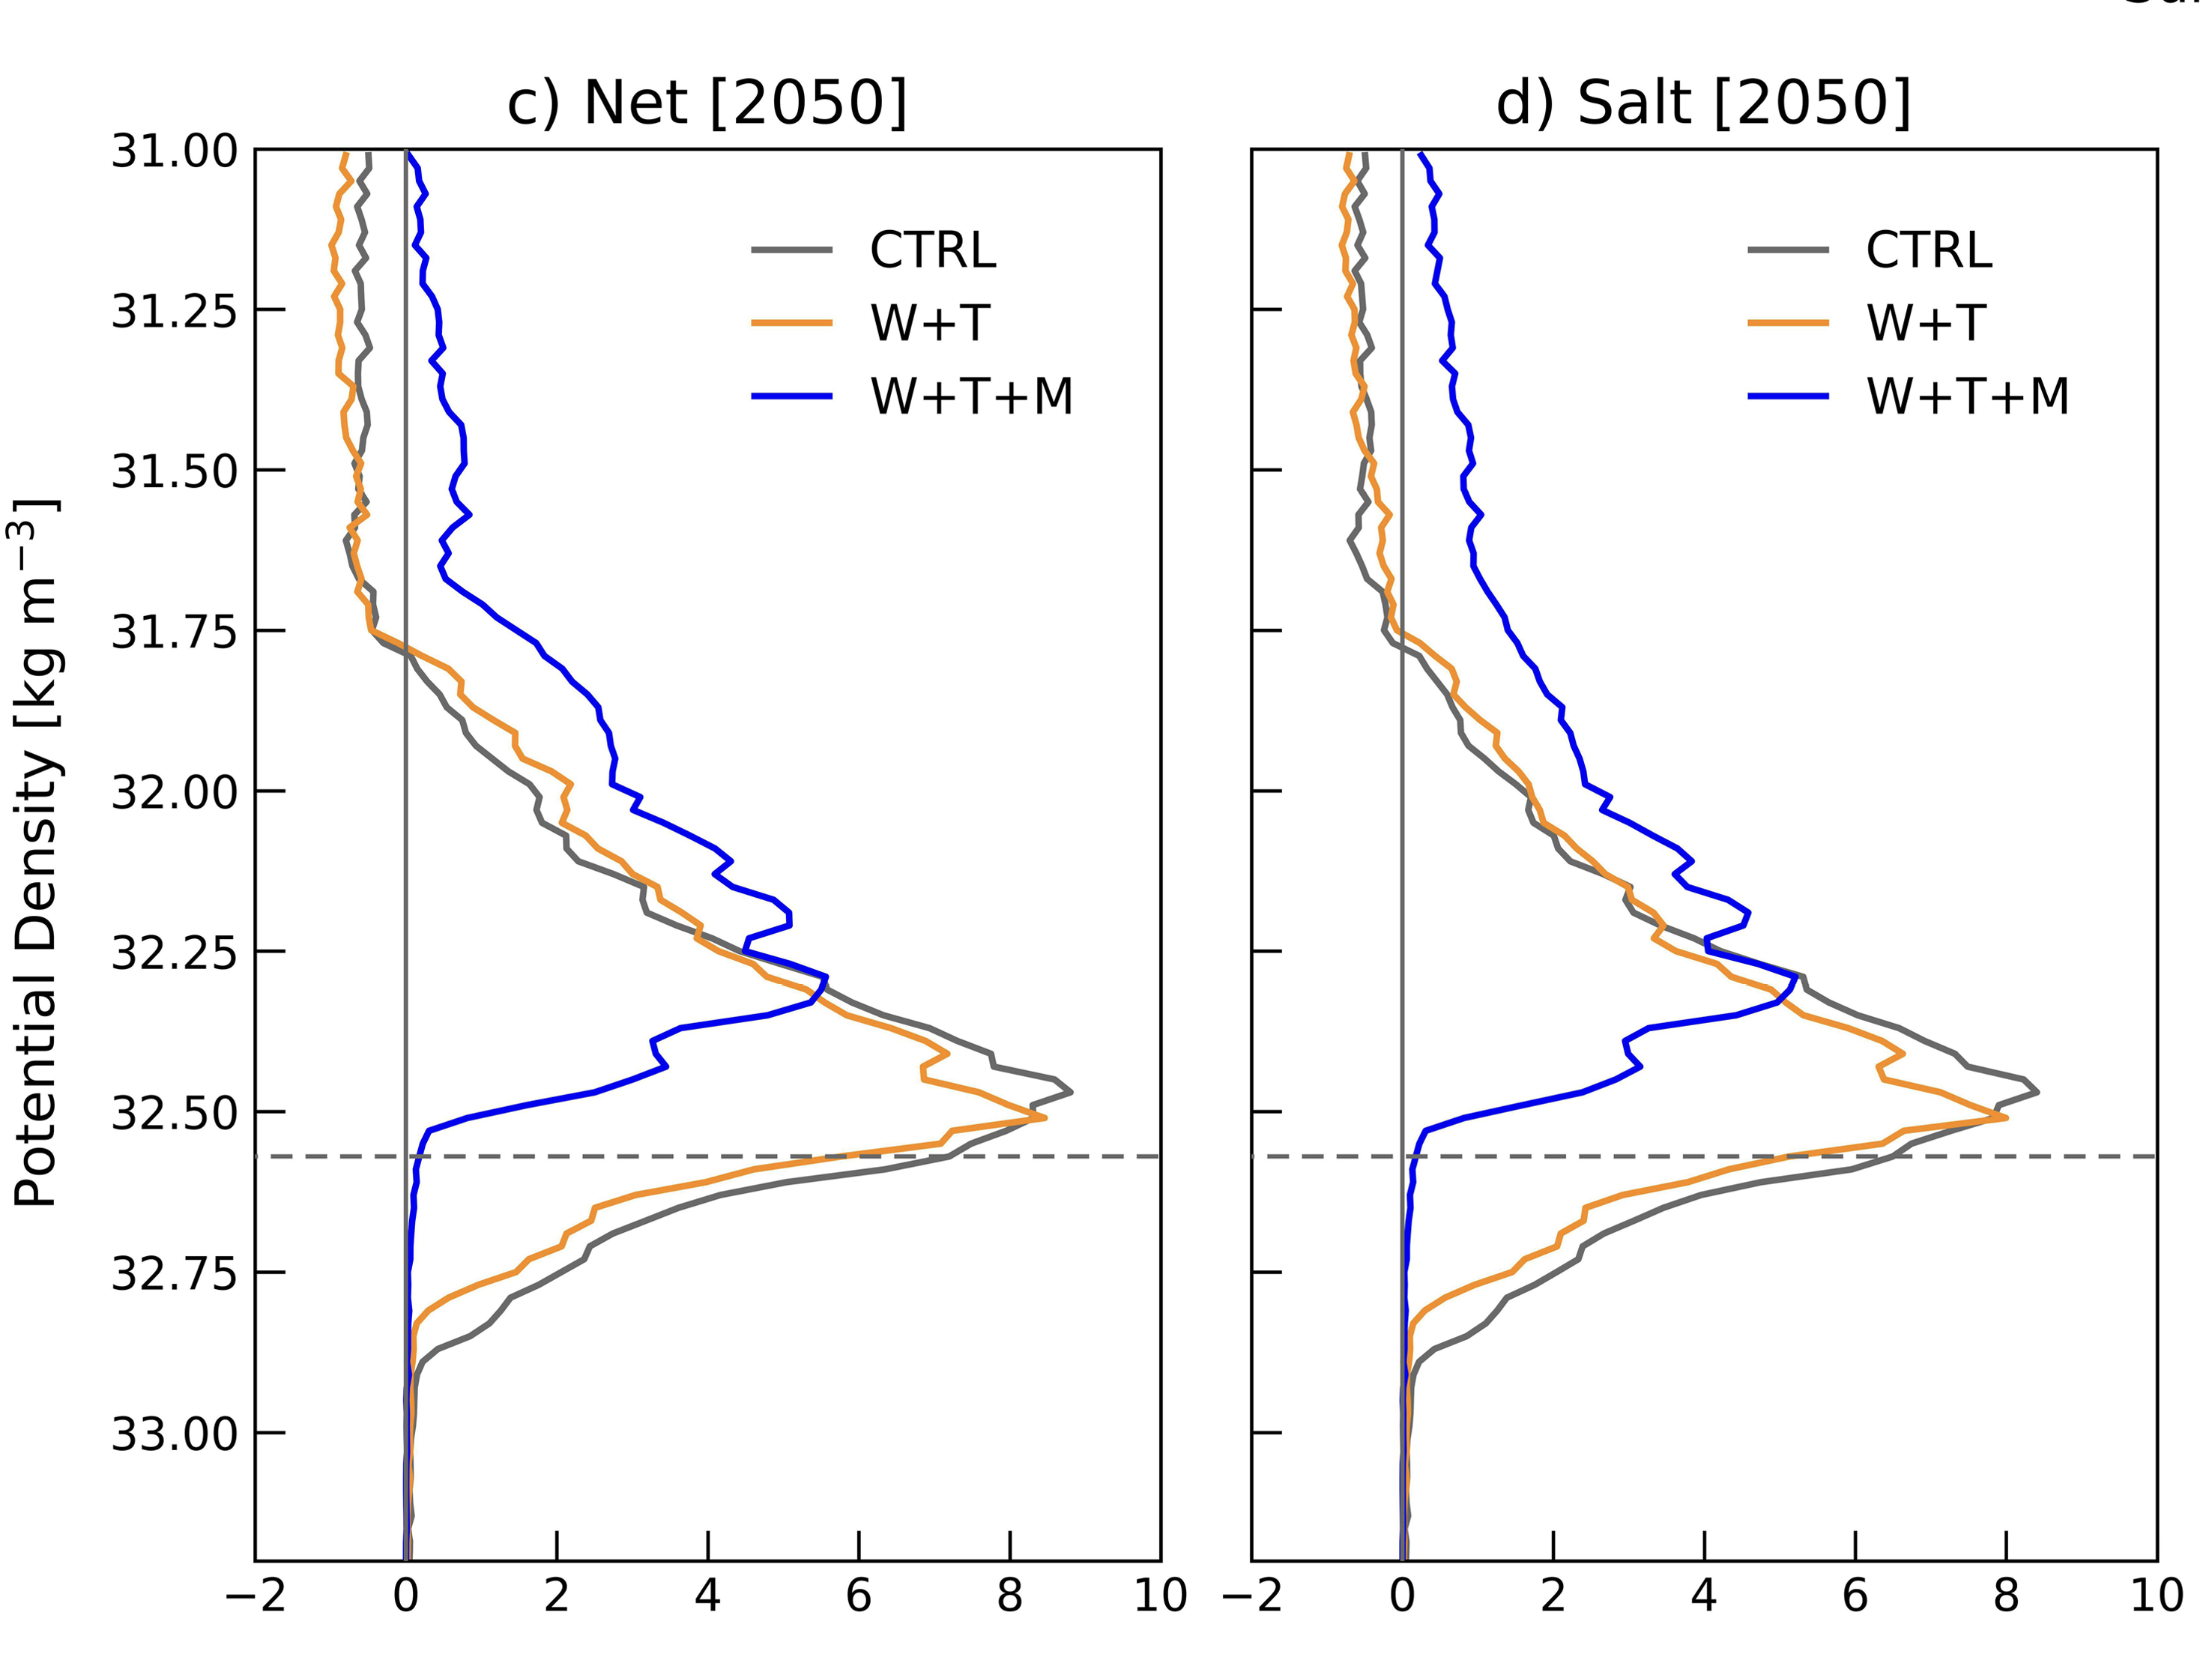

In [1]:
import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20) 

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36077/status,
Dashboard: /proxy/36077/status,Workers: 4
Total threads: 16,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44371,Workers: 4
Dashboard: /proxy/36077/status,Total threads: 16
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:36487,Total threads: 4
Dashboard: /proxy/43511/status,Memory: 45.00 GiB
Nanny: tcp://127.0.0.1:42167,


In [15]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
cntl = '01deg_jra55v13_ryf9091'
expt_qian = '01deg_jra55v13_ryf9091_qian_wthp'
expt_qian_m = '01deg_jra55v13_ryf9091_qian_wthmp'

# database for ssp585_wind_thermal simulation
expt_session =cc.database.create_session('/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/databases/wind-thermal_trial.db')
expt_ssp585 = '01deg_jra55v13_ssp585_windthermal'
expt_ssp245 = '01deg_jra55v13_ssp245_windthermal'

In [4]:
def save_SWMT(expt, session, start_time, end_time, outpath, lat_north = -59, n = None):
    '''
    Computes southern ocean surface water-mass transformation rates (partitioned into transformation from heat 
    and freshwater) referenced to 1000 db from monthly ACCESS-OM2 output.
    Suitable for analysis of high-resolution (0.1 degree) output (the scattered .load()'s allowed this)
    
    expt - text string indicating the name of the experiment
    session - a database session created by cc.database.create_session()  
    start_time - text string designating the start month of the analysis ('YYYY-MM', e.g. '1905-01')
    end_time - text string indicating the end month of the analysis ('YYY-MM', e.g. '1905-12')
    outpath - text string indicating directory where output databases are to be saved (3 xarray databases, can
    modify to combine these if memory permits)
    lat_north - function computed processes between lat = -90 and lat = lat_north
    n - designate if a subset of output files is to be considered (see cc.querying.getvar)
    
    NOTE: this function assumes you are averaging over an integer number of years (though the start month 
    need not be january, e.g. can have start_time = '1905-05', end_time = '1907-04' etc), modify if otherwise.
    
    NOTE: assumes surface_temp and surface_salt variables are in potential temperature (K) and practical
    salinity (PSU), simplifications may be made if conservative temperature (C) and absolute salinity (g/kg)
    are computed online
    
    required modules:
    xarray as xr
    numpy as np
    cosima_cookbook as cc
    from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 
    '''
    ## getvar all required variables
    SST = cc.querying.getvar(expt, 'surface_temp', session, frequency='1 monthly') - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt, 'surface_salt', session, frequency='1 monthly')      # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt, 'pme_river', session, frequency='1 monthly')       # mass flux of precip - evap + river
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005 * melt instead
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly')         # mass flux of salt from ice formation/melt
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly') # mass flux of salt from surface salinity restoring

    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    sfc_hflux_from_runoff = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, frequency='1 monthly') # W/m²
    sfc_hflux_coupler = cc.querying.getvar(expt, 'sfc_hflux_coupler', session, frequency='1 monthly')         # W/m²
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, frequency='1 monthly')                 # W/m²
    frazil_3d_int_z = cc.querying.getvar(expt, 'frazil_3d_int_z', session, frequency='1 monthly')             # W/m²
    geolon_t = cc.querying.getvar(expt, 'geolon_t', session, n=1)
    geolat_t = cc.querying.getvar(expt, 'geolat_t', session, n=1)
    
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time, end_time)
    lat_slice = slice(-90, lat_north)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    
    lon_t = geolon_t.sel(yt_ocean=lat_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice)
    
    ## extract coordinate arrays
    yt_ocean = SST.yt_ocean.values
    xt_ocean = SST.xt_ocean.values
    st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
    time_monthly = SST.time.values
    
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SST.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap

    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')

    ## compute net surface heat flux from its component terms
    net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0 + 1) * depth
    pressure = xr.DataArray(p_from_z(depth_tile, lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU, pressure, lon_t, lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    pot_rho_1 = pot_rho_1.load()
    
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})

    # Note that the salt fluxes have units of (kg of salt)/m²/s, while β has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m²/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    salt_transformation = haline_contraction * (SSS * pme_river - (sfc_salt_flux_ice + sfc_salt_flux_restore)*1000) * days_per_month #! before was PSU, why?
    salt_transformation = salt_transformation.load()

    # Compute heat transformation (no density binning)
    thermal_expansion = xr.DataArray(alpha(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'thermal expansion coefficient (constant conservative temp)', attrs = {'units':'1/K'})
    heat_transformation = thermal_expansion * net_surface_heating * days_per_month
    heat_transformation = heat_transformation.load()
    
    # Record the time bounds before summing through time (just to make sure it's consistent with requested years)
    time_bounds = str(salt_transformation.coords['time.year'][0].values)+'_'+str(salt_transformation.coords['time.month'][0].values)+'-'+str(salt_transformation.coords['time.year'][-1].values)+'_'+str(salt_transformation.coords['time.month'][-1].values)
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) ## alter if this density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
    
    bin_bottoms = isopycnal_bins[:-1]
    binned_salt_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', 'yt_ocean', 'xt_ocean'], name = 'salt transformation in isopycnal bins summed over time')
    binned_salt_transformation.chunk({'isopycnal_bins':1})
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform
    print('salt_transformation binning done')
    
    binned_heat_transformation = xr.DataArray(np.zeros((len(bin_bottoms), len(yt_ocean), len(xt_ocean))), coords = [bin_bottoms, yt_ocean,xt_ocean], dims = ['isopycnal_bins', 'yt_ocean', 'xt_ocean'], name = 'heat transformation in isopycnal bins summed over time')
    binned_heat_transformation.chunk({'isopycnal_bins':1})

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (heat_transformation * bin_mask).sum(dim = 'time') 
        masked_transform = masked_transform.where(masked_transform != 0)
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform
    print('heat_transformation binning done')
    
    ndays = days_per_month.sum().values
    salt_transformation = binned_salt_transformation/ndays
    c_p = 3992.1
    heat_transformation = binned_heat_transformation/c_p/ndays
    
    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2
    
    # this procedure defines fluxes from lighter to denser classes as negative, I want the opposite
    salt_transformation = salt_transformation *-1
    heat_transformation = heat_transformation *-1
    
    # Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
    ds = xr.Dataset({'binned_salt_transformation': salt_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+f'/ST_{expt}_'+time_bounds+'.nc')
    ds = xr.Dataset({'binned_heat_transformation': heat_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+f'/HT_{expt}_'+time_bounds+'.nc')
    #############################################################
    net_transformation = heat_transformation + salt_transformation
    #############################################################
    del(heat_transformation, salt_transformation) ## unecessary for lower res or smaller time
    # wanted to rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
    net_transformation.coords['isopycnal_bins'] = isopycnal_bin_mid
    ds = xr.Dataset({'surface_water_mass_transformation': net_transformation, 'time_bounds': time_bounds})
    ds.to_netcdf(outpath+f'/SWMT_{expt}_'+time_bounds+'.nc')
    del(net_transformation)
    return outpath, time_bounds ## helpful for re-loading

In [11]:
%%time
## Make a temporary directory to stash a few files
#!mkdir -p /g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT_temp
outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT_temp/' # use a path where you have write permission

start_time = '2154-01'
end_time = '2154-12'
outpath, time_bounds = save_SWMT(expt_ssp585, expt_session, start_time, end_time, outpath)

salt_transformation binning done
heat_transformation binning done
CPU times: user 1min 36s, sys: 1min 22s, total: 2min 58s
Wall time: 2min 57s


In [20]:
%%time
start_time = '2155-01'
end_time = '2155-12'
outpath, time_bounds = save_SWMT(expt_ssp245, expt_session, start_time, end_time, outpath)

salt_transformation binning done
heat_transformation binning done
CPU times: user 1min 34s, sys: 1min 20s, total: 2min 55s
Wall time: 3min 2s


In [17]:
%%time
start_time = '2155-01'
end_time = '2155-12'
outpath, time_bounds = save_SWMT(cntl, session, start_time, end_time, outpath)

salt_transformation binning done
heat_transformation binning done
CPU times: user 3min 46s, sys: 1min 29s, total: 5min 15s
Wall time: 8min 29s


In [8]:
outpath = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/SWMT_temp/' # use a path where you have write permission

#time_bounds = '2157_1-2158_12'
#time_bounds

'2157_1-2158_12'

In [21]:
def get_SWMT(outpath, expt, time_bounds):

    net_transformation = xr.open_dataset(outpath + f'/SWMT_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(outpath + f'/HT_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(outpath + f'/ST_{expt}_' + time_bounds + '.nc', chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation

    return net_transformation, heat_transformation, salt_transformation


In [9]:
area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # needed for the plots I'll provide.
swmt, heat, salt = get_SWMT(outpath, expt, time_bounds)

## sum over region, convert to Sv
isopycnal_bin_mid = swmt.isopycnal_bins
swmt_sum = (swmt * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_sum = (heat * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_sum = (salt * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values

ssp585 experiment

In [10]:
swmt_pert, heat_pert, salt_pert = get_SWMT(outpath, expt_pert, time_bounds)

## sum over region, convert to Sv
isopycnal_bin_mid_pert = swmt_pert.isopycnal_bins
swmt_sum_pert = (swmt_pert * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_sum_pert = (heat_pert * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_sum_pert = (salt_pert * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values

In [11]:
swmt_qian, heat_qian, salt_qian = get_SWMT(outpath, expt_qian, time_bounds)

## sum over region, convert to Sv
isopycnal_bin_mid_qian = swmt_qian.isopycnal_bins
swmt_sum_qian = (swmt_qian * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_sum_qian = (heat_qian * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_sum_qian = (salt_qian * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values

In [34]:
swmt_qian_m, heat_qian_m, salt_qian_m = get_SWMT(outpath, expt_qian_m, time_bounds)

## sum over region, convert to Sv
isopycnal_bin_mid_qian_m = swmt_qian.isopycnal_bins
swmt_sum_qian_m = (swmt_qian_m * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_sum_qian_m = (heat_qian_m * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_sum_qian_m = (salt_qian_m * area_t / 1e6).sum(['xt_ocean', 'yt_ocean']).values

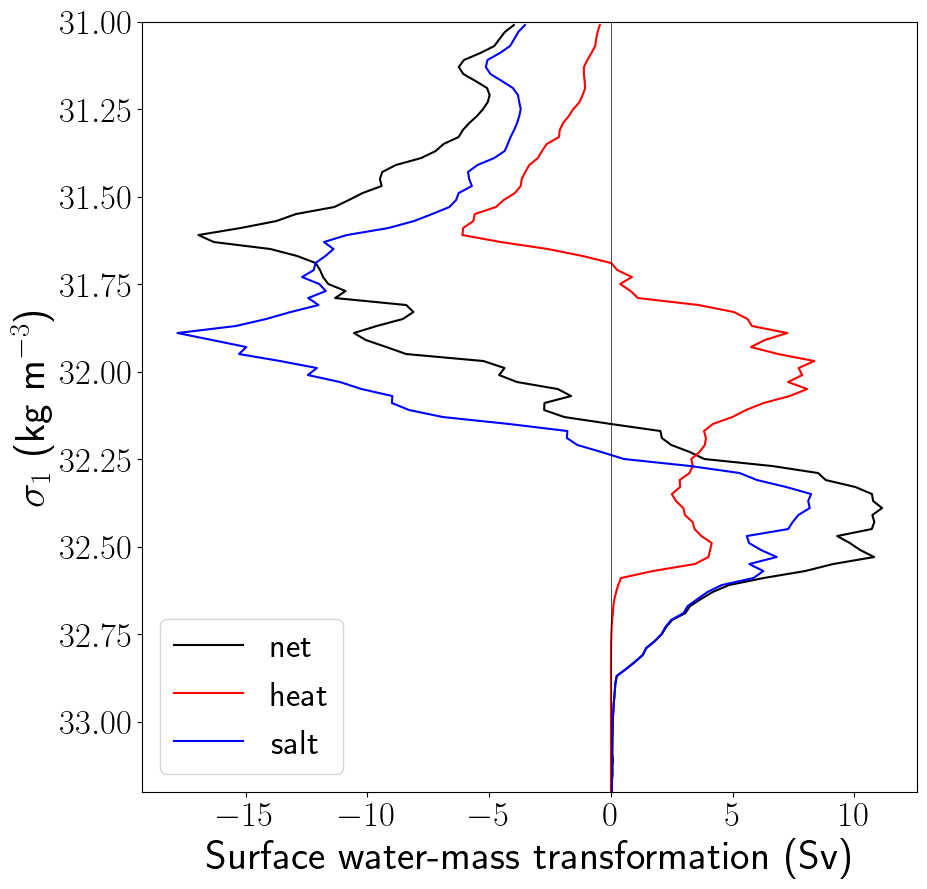

In [21]:
figure = plt.figure(num=1, figsize = (10, 10))

plt.plot(swmt_sum, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_sum, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_sum, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

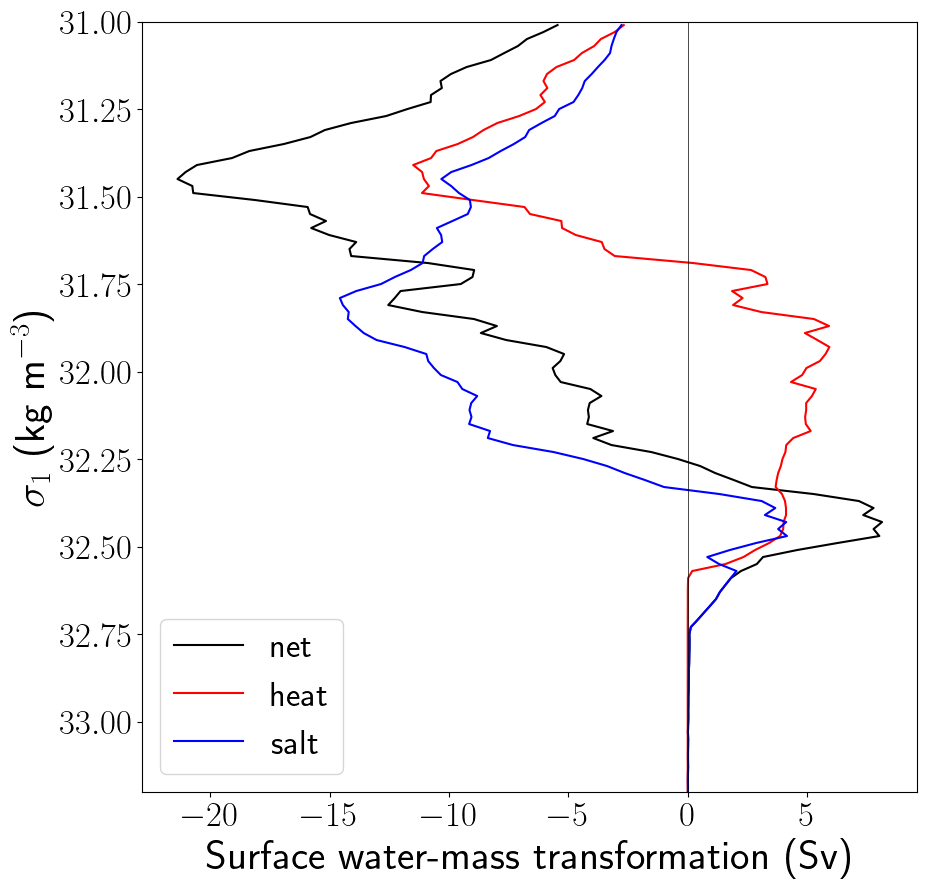

In [22]:
figure = plt.figure(num=1, figsize = (10, 10))

plt.plot(swmt_sum_pert, isopycnal_bin_mid_pert, color = 'k', label='net')
plt.plot(heat_sum_pert, isopycnal_bin_mid_pert, color = 'r', label='heat')
plt.plot(salt_sum_pert, isopycnal_bin_mid_pert, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize=30)
plt.legend(loc=3, fontsize = 25);

Antarctic shelf. 

In [22]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [15]:
swmt_shelf, shelf_mask = shelf_mask_isobath(swmt)
heat_shelf, shelf_mask = shelf_mask_isobath(heat)
salt_shelf, shelf_mask = shelf_mask_isobath(salt)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_shelf_sum_cntl = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_shelf_sum_cntl = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_shelf_sum_cntl = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values


swmt_shelf, shelf_mask = shelf_mask_isobath(swmt_pert)
heat_shelf, shelf_mask = shelf_mask_isobath(heat_pert)
salt_shelf, shelf_mask = shelf_mask_isobath(salt_pert)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_shelf_sum_pert = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_shelf_sum_pert = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_shelf_sum_pert = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values


swmt_shelf, shelf_mask = shelf_mask_isobath(swmt_qian)
heat_shelf, shelf_mask = shelf_mask_isobath(heat_qian)
salt_shelf, shelf_mask = shelf_mask_isobath(salt_qian)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_shelf_sum_qian = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_shelf_sum_qian = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_shelf_sum_qian = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values


In [35]:
swmt_shelf, shelf_mask = shelf_mask_isobath(swmt_qian_m)
heat_shelf, shelf_mask = shelf_mask_isobath(heat_qian_m)
salt_shelf, shelf_mask = shelf_mask_isobath(salt_qian_m)
area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
swmt_shelf_sum_qian_m = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
heat_shelf_sum_qian_m = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
salt_shelf_sum_qian_m = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values


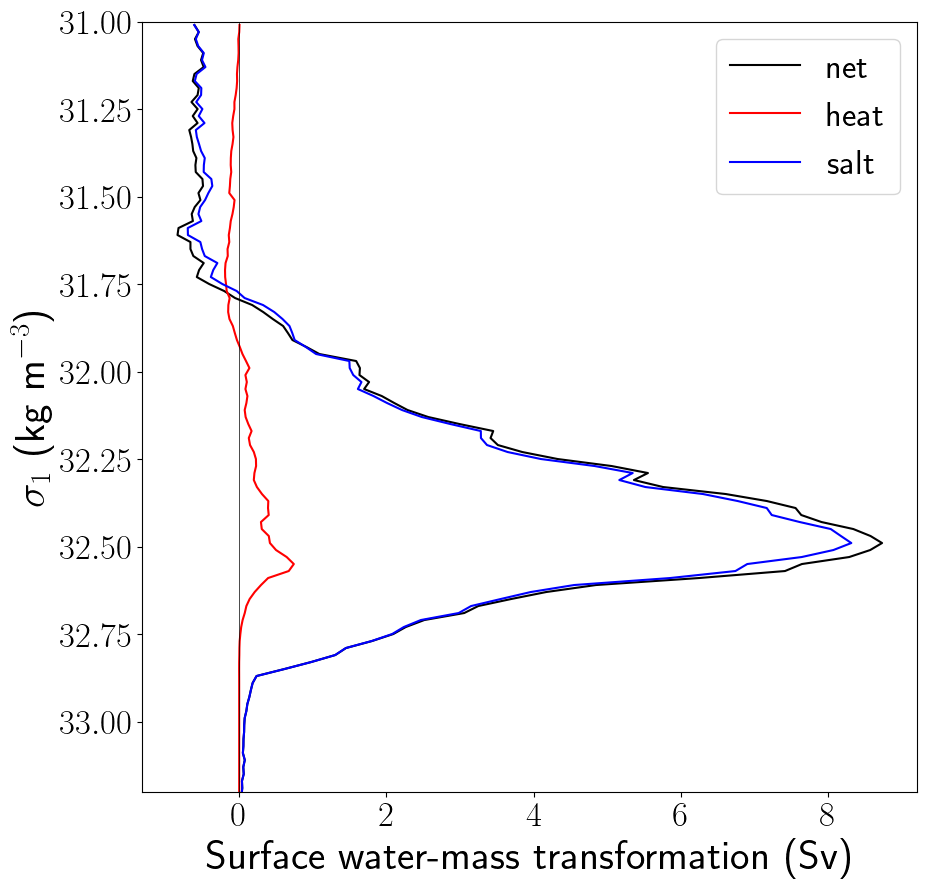

In [25]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_shelf_sum_cntl, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_shelf_sum_cntl, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_shelf_sum_cntl, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);

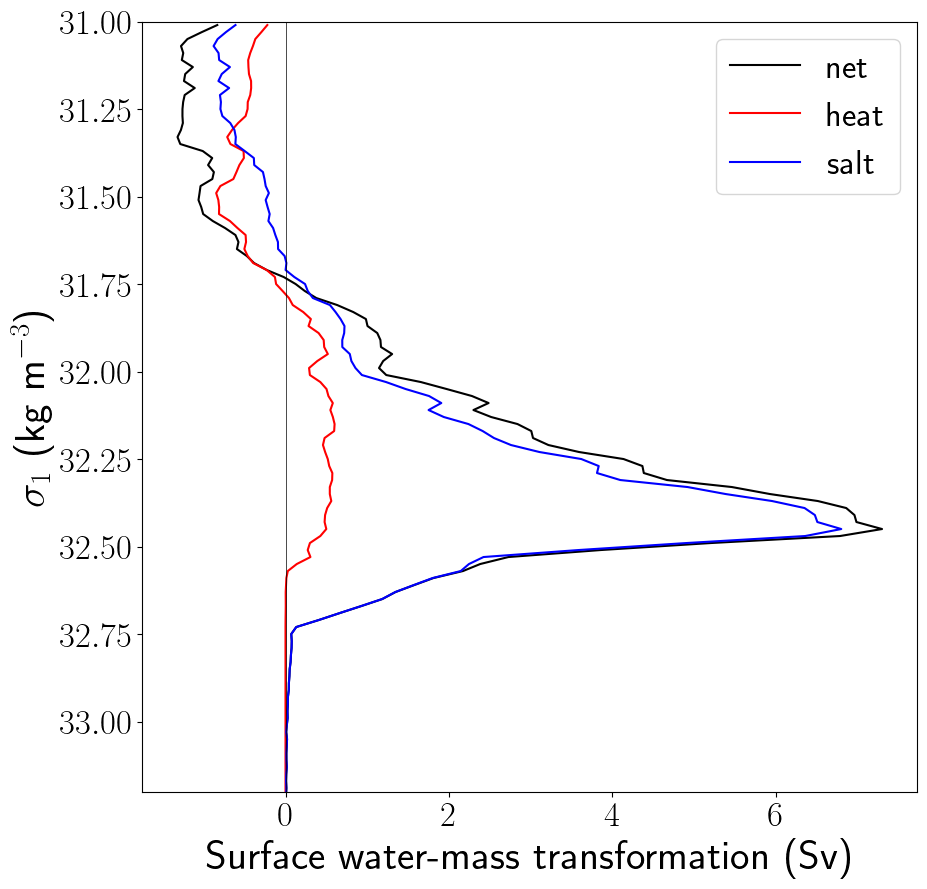

In [26]:
figure = plt.figure(num = 1, figsize = (10, 10))

plt.plot(swmt_shelf_sum_pert, isopycnal_bin_mid, color = 'k', label='net')
plt.plot(heat_shelf_sum_pert, isopycnal_bin_mid, color = 'r', label='heat')
plt.plot(salt_shelf_sum_pert, isopycnal_bin_mid, color = 'b', label='salt')
plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 25);

Now experiment. 

In [16]:
rc('text', usetex=True)
rc('xtick', labelsize=18) 
rc('ytick', labelsize=18) 
rc('axes', labelsize=18) 

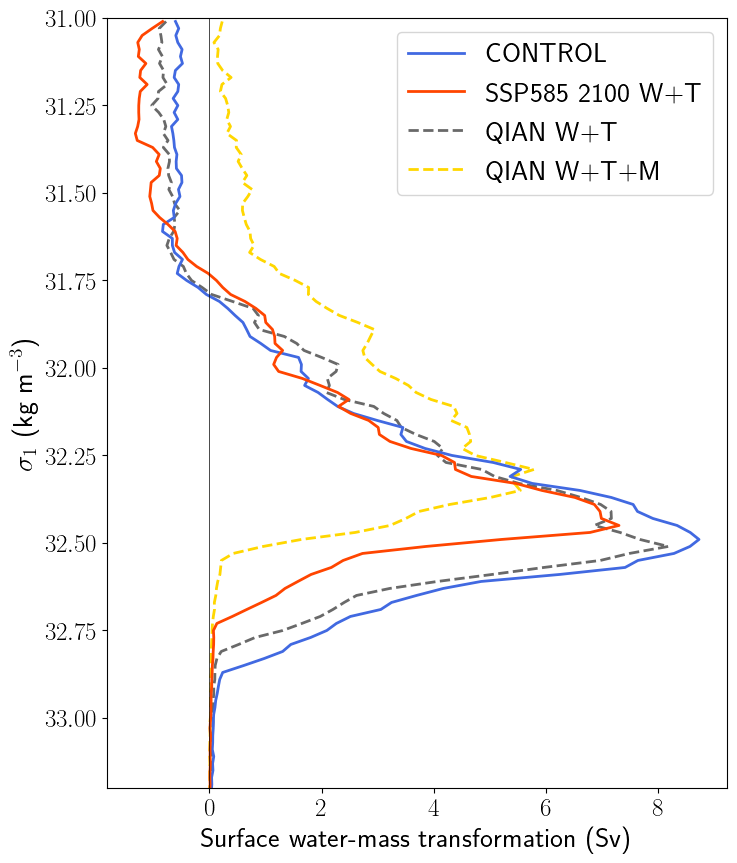

In [39]:
figure = plt.figure(num = 1, figsize = (8, 10))

plt.plot(swmt_shelf_sum_cntl, isopycnal_bin_mid, color = 'royalblue', lw=2, label='CONTROL')
plt.plot(swmt_shelf_sum_pert, isopycnal_bin_mid, color = 'orangered', lw=2, zorder=2, label='SSP585 2100 W+T')
plt.plot(swmt_shelf_sum_qian, isopycnal_bin_mid, color = 'dimgrey', lw=2, zorder=1, ls = '--',label='QIAN W+T')
plt.plot(swmt_shelf_sum_qian_m, isopycnal_bin_mid, color = 'gold', lw=2, zorder=1, ls = '--',label='QIAN W+T+M')

plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 20)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 20)
plt.legend(loc=1, fontsize = 20);

figfile = f'/home/561/hd4873/project3/figs/swmt_ssp585_years_2157-2158_qian_comparison.jpg'
figure.savefig(figfile, bbox_inches='tight', dpi=300)

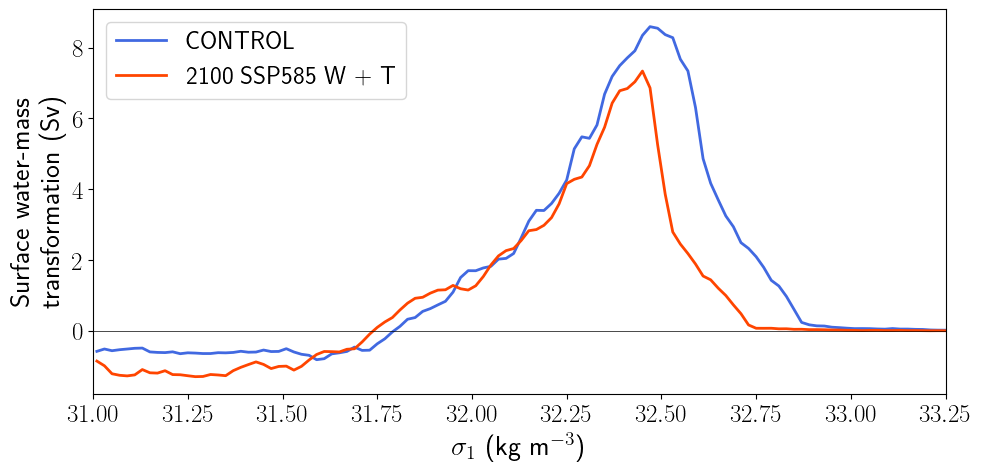

In [68]:
fig = plt.figure(num = 1, figsize = (11, 5))

plt.plot(isopycnal_bin_mid, swmt_shelf_sum_cntl, color = 'royalblue', lw=2, label='CONTROL')
plt.plot(isopycnal_bin_mid, swmt_shelf_sum_pert, color = 'orangered', lw=2, label='2100 SSP585 W + T')
plt.plot([31, 33.25], [0, 0], 'k', linewidth=0.5)
plt.xlim((31, 33.25))
plt.xlabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 20)
plt.ylabel(f'Surface water-mass \ntransformation (Sv)', fontsize = 20)
plt.legend(loc=0, fontsize = 18);
plt.show()

figfile = f'/home/561/hd4873/project3/figs/swmt_ssp585_years_2155-2158.jpg'
fig.savefig(figfile, bbox_inches='tight', dpi=300)

# Plot SWMT as a function of experiment year. 

In [23]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [31]:
def Antarctic_SWMT(outpath, expt, session, time_bounds):
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1) # needed for the plots I'll provide.
    swmt, heat, salt = get_SWMT(outpath, expt, time_bounds)
    isopycnal_bin_mid = swmt.isopycnal_bins

    # mask to shelf
    swmt_shelf, shelf_mask = shelf_mask_isobath(swmt)
    heat_shelf, shelf_mask = shelf_mask_isobath(heat)
    salt_shelf, shelf_mask = shelf_mask_isobath(salt)
    area_t_shelf, shelf_mask = shelf_mask_isobath(area_t)
    
    ## sum over region, convert to Sv
    swmt_shelf_sum = (swmt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
    heat_shelf_sum = (heat_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values
    salt_shelf_sum = (salt_shelf * area_t_shelf / 1e6).sum(['xt_ocean', 'yt_ocean']).values

    return swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum, isopycnal_bin_mid

def SWMT_by_year():
    rc('text', usetex=True)
    rc('xtick', labelsize=18) 
    rc('ytick', labelsize=18) 
    rc('axes', labelsize=18) 
    
    figure = plt.figure(num = 1, figsize = (8, 10))
    plt.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
    plt.ylim((33.2, 31))
    plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 20)
    plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 20)
    
    return figure

2150_1-2150_12
2151_1-2151_12
2152_1-2152_12
2153_1-2153_12
2154_1-2154_12


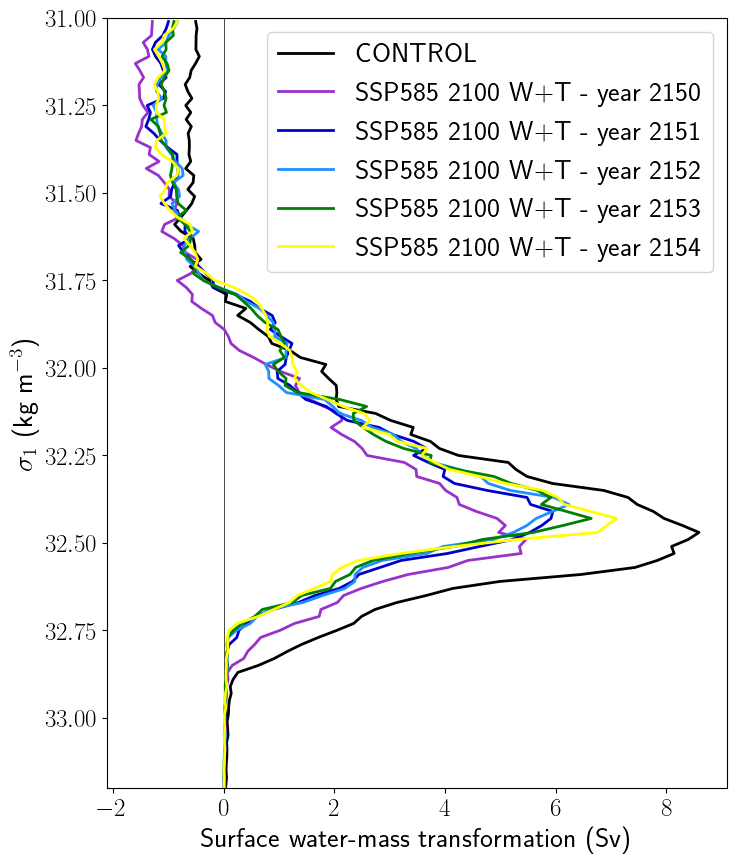

In [40]:
fig = SWMT_by_year()
colors=['darkorchid','mediumblue','dodgerblue','green','yellow','oranbge','red','violet']
swmt_shelf_sum_cntl, heat_shelf_sum_cntl, salt_shelf_sum_cntl, isopycnal_bin_mid = Antarctic_SWMT(outpath, cntl, session, '2155_1-2155_12')
plt.plot(swmt_shelf_sum_cntl, isopycnal_bin_mid, color = 'k', lw=2, label='CONTROL')

year = 2150
for i, yr in enumerate(np.arange(2150, 2155, 1)):
    time_bounds= f'{yr}_1-{yr}_12'
    print(time_bounds)
    swmt_shelf_sum_585, heat_shelf_sum_585, salt_shelf_sum_585, isopycnal_bin_mid = Antarctic_SWMT(outpath, expt_ssp585, expt_session, time_bounds)
    plt.plot(swmt_shelf_sum_585, isopycnal_bin_mid, color = colors[i], lw=2, zorder=2, label=f'SSP585 2100 W+T - year {yr}')

plt.legend(loc=1, fontsize = 16);
plt.show()

2150_1-2150_12
2151_1-2151_12
2152_1-2152_12
2153_1-2153_12
2154_1-2154_12
2155_1-2155_12


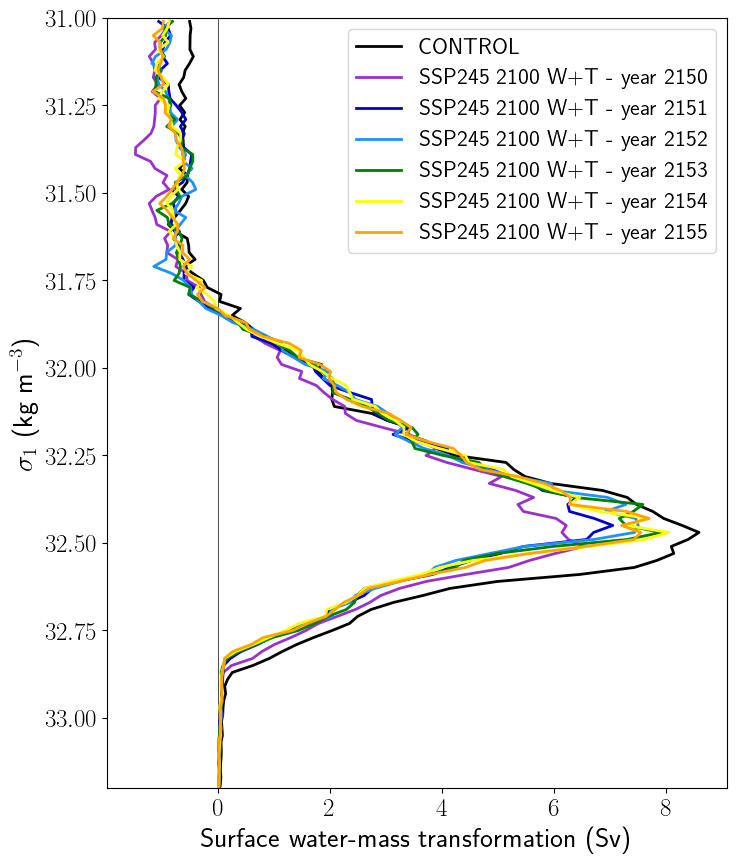

In [42]:
fig = SWMT_by_year()
colors=['darkorchid','mediumblue','dodgerblue','green','yellow','orange','red','violet']
swmt_shelf_sum_cntl, heat_shelf_sum_cntl, salt_shelf_sum_cntl, isopycnal_bin_mid = Antarctic_SWMT(outpath, cntl, session, '2155_1-2155_12')
plt.plot(swmt_shelf_sum_cntl, isopycnal_bin_mid, color = 'k', lw=2, label='CONTROL')

year = 2150
for i, yr in enumerate(np.arange(2150, 2156, 1)):
    time_bounds= f'{yr}_1-{yr}_12'
    print(time_bounds)
    swmt_shelf_sum_245, heat_shelf_sum_245, salt_shelf_sum_245, isopycnal_bin_mid = Antarctic_SWMT(outpath, expt_ssp245, expt_session, time_bounds)
    plt.plot(swmt_shelf_sum_245, isopycnal_bin_mid, color = colors[i], lw=2, zorder=2, label=f'SSP245 2100 W+T - year {yr}')

plt.legend(loc=1, fontsize = 16);
plt.show()

# Calculate percentage changes

In [54]:
from scipy.integrate import simpson
from numpy import trapz

In [67]:
area = trapz(swmt_shelf_sum_cntl[np.where((isopycnal_bin_mid >= 32.25) & (isopycnal_bin_mid <= 32.6))], dx=0.02)
print("area =", area)

area = simpson(swmt_shelf_sum_cntl[np.where((isopycnal_bin_mid >= 32.25) & (isopycnal_bin_mid <= 32.6))], dx=0.02)
area

area = 2.334383046897688


2.3410839747428405

In [68]:
area = trapz(swmt_shelf_sum_pert[np.where((isopycnal_bin_mid >= 32.25) & (isopycnal_bin_mid <= 32.6))], dx=0.02)
print("area =", area)

area = simpson(swmt_shelf_sum_pert[np.where((isopycnal_bin_mid >= 32.25) & (isopycnal_bin_mid <= 32.6))], dx=0.02)
area

area = 1.62612376349979


1.627263667099162

In [69]:
100 - (Out[68]/Out[67])*100

30.491016783030574

In [70]:
100 - (1.627263667099162/2.3410839747428405)*100

30.491016783030574

In [25]:
isopycnal_bin_mid.where(isopycnal_bin_mid > 32.5)

<xarray.DataArray 'isopycnal_bins' (isopycnal_bins: 124)>
array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan, 32.51, 32.53, 32.55, 32.57, 32.59, 32.61,
       32.63, 32.65, 32.67, 32.69, 32.71, 32.73, 32.75, 32.77, 32.79,
       32.81, 32.83, 32.85, 32.87, 32.89, 32.91, 32.93, 32.95, 32.97,
       32.99, 33.01, 33.03, 33.05, 33.07, 33.09, 33.11, 33.13, 33.15,
       33.17, 33.19, 33.21, 33.23, 33.25, 33.27, 33.29, 33.31, 33.33,
       33.35, 33.37, 33.39, 33.41, 33.43, 33.45, 33.47])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 31.01 31.03 31.05 ... 33.45 33.47

In [48]:
swmt_shelf_sum_cntl[np.where(isopycnal_bin_mid > 32.5)].sum()*.02

1.4404434087658837

In [49]:
swmt_shelf_sum_pert[np.where(isopycnal_bin_mid > 32.5)].sum()*0.02

0.40047943790626833

In [41]:
Out[37]/Out[36]*100

27.802511051050843

In [42]:
100-Out[41]

72.19748894894916

In [24]:
swmt_shelf_sum_cntl

array([-0.6063921 , -0.54854544, -0.60058025, -0.5653633 , -0.48823365,
       -0.51782214, -0.48190806, -0.60802043, -0.63029438, -0.54859147,
       -0.56482281, -0.64809695, -0.56399972, -0.63046182, -0.56499234,
       -0.6778582 , -0.65286967, -0.63544848, -0.62447305, -0.58088438,
       -0.59452241, -0.58979457, -0.49882271, -0.49098375, -0.55323107,
       -0.52624164, -0.60371704, -0.64460756, -0.62833181, -0.8239631 ,
       -0.8373764 , -0.66189952, -0.66175976, -0.62238431, -0.48129938,
       -0.54438241, -0.57531131, -0.40699029, -0.20356429, -0.05567064,
        0.17679106,  0.32626915,  0.45672656,  0.59690527,  0.6617598 ,
        0.72286799,  0.91441617,  1.08904444,  1.58830817,  1.63927366,
        1.63314197,  1.76369337,  1.69616309,  1.93576893,  2.10592666,
        2.2863    ,  2.56757647,  2.9910146 ,  3.4491911 ,  3.41279622,
        3.51191249,  3.8441293 ,  4.32455795,  5.0566907 ,  5.55000544,
        5.35956768,  5.75632258,  6.60642262,  7.16415133,  7.55